In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

df = pd.read_csv('Pathogen detection Salmonella enterica.csv')

print(df.info())
print(df.head())

#drop na from target variable and X variables
df = df.dropna(subset=['Serovar', 'AMR genotypes', 'Isolation source', 'Isolation type', 'Location'])

#drop columns we won't be using
df = df.drop(columns=['#Organism group','Isolate identifiers', 'Strain', 'Isolate','Create date','SNP cluster', 'Min-same','Min-diff','BioSample', 'Assembly', 'Computed types'])
print('After dropping columns:', df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558819 entries, 0 to 558818
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   #Organism group      558819 non-null  object 
 1   Strain               521387 non-null  object 
 2   Isolate identifiers  558784 non-null  object 
 3   Serovar              271461 non-null  object 
 4   Isolate              558819 non-null  object 
 5   Create date          558819 non-null  object 
 6   Location             493788 non-null  object 
 7   Isolation source     266854 non-null  object 
 8   Isolation type       519107 non-null  object 
 9   SNP cluster          503772 non-null  object 
 10  Min-same             465867 non-null  float64
 11  Min-diff             373323 non-null  float64
 12  BioSample            558813 non-null  object 
 13  Assembly             468778 non-null  object 
 14  AMR genotypes        543238 non-null  object 
 15  Computed types   

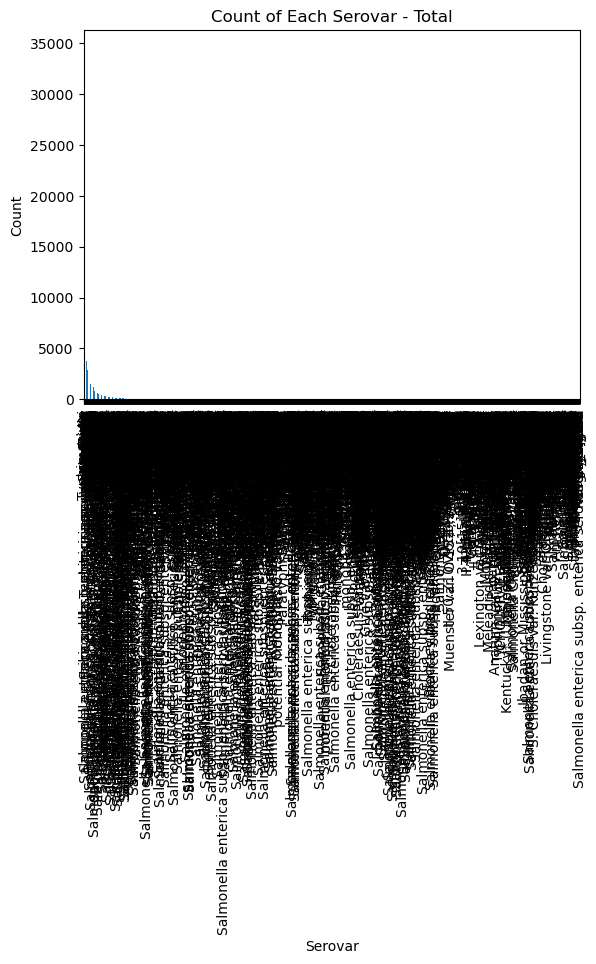

In [2]:
import matplotlib.pyplot as plt
serovar_vc = df['Serovar'].value_counts()

serovar_vc.plot(kind='bar')
plt.xlabel('Serovar')
plt.ylabel('Count')
plt.title('Count of Each Serovar - Total')
plt.xticks(rotation=90)
plt.show()

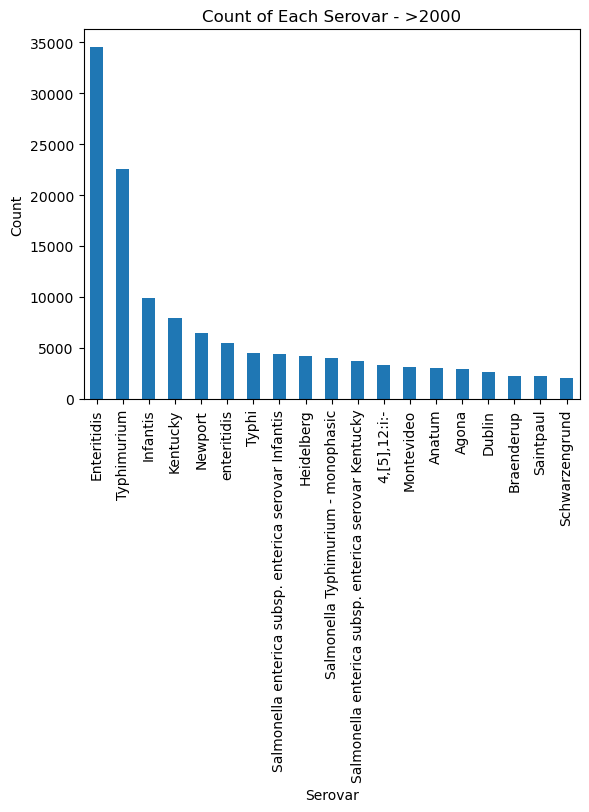

In [3]:
# Label Encode Serovar Target Variable
## First, take out all of the serovars that show up less than 1000 times.

sv_vc = serovar_vc[serovar_vc < 2000]
df['Serovar'] = df['Serovar'].apply(lambda x: None if x in sv_vc else x)
df = df.dropna(subset=['Serovar'])

sv_vcs = df['Serovar'].value_counts()
sv_vcs.plot(kind='bar')
plt.xlabel('Serovar')
plt.ylabel('Count')
plt.title('Count of Each Serovar - >2000')
plt.xticks(rotation=90)
plt.show()



In [4]:
label_encoder = LabelEncoder()
df['serovars_le'] = label_encoder.fit_transform(df['Serovar'])
df = df.drop(columns=['Serovar'])
print(df['serovars_le'].value_counts())
print(df.info(verbose=True))
print('na_vals', df['serovars_le'].isna().sum())
print('sv count', df['serovars_le'].count())

serovars_le
5     34522
17    22596
7      9934
8      7922
10     6457
18     5511
16     4469
13     4448
6      4217
12     3995
14     3768
0      3363
9      3164
2      3021
1      2910
4      2619
3      2259
11     2216
15     2067
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 129458 entries, 0 to 558713
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Location          129458 non-null  object
 1   Isolation source  129458 non-null  object
 2   Isolation type    129458 non-null  object
 3   AMR genotypes     129458 non-null  object
 4   serovars_le       129458 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 5.9+ MB
None
na_vals 0
sv count 129458


In [5]:
# One Hot Encode AMR Genotypes
## Need to encode differently since each row has a list of genotypes associated
df['AMR genotypes'] = df['AMR genotypes'].apply(lambda x: str(x).split(','))
genotypes = []
for genes in df['AMR genotypes']:
    for gene in genes:
        gene = gene.split('=')[0]
        if gene in genotypes:
            continue
        else:
            genotypes.append(gene)

for genotype in genotypes:
    df[f'genotype_{genotype}'] = df['AMR genotypes'].apply(lambda x: 1.0 if genotype in x else 0.0)
df = df.drop(columns=['AMR genotypes'])

print('After AMR Encode:', df.info())
print('na after AMR', df['serovars_le'].isna().sum())

/var/folders/lx/37plgr6128137bq62kjnknmw0000gn/T/ipykernel_33244/155341017.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'genotype_{genotype}'] = df['AMR genotypes'].apply(lambda x: 1.0 if genotype in x else 0.0)
/var/folders/lx/37plgr6128137bq62kjnknmw0000gn/T/ipykernel_33244/155341017.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'genotype_{genotype}'] = df['AMR genotypes'].apply(lambda x: 1.0 if genotype in x else 0.0)
/var/folders/lx/37plgr6128137bq62kjnknmw0000gn/T/ipykernel_33244/155341017.py:14: Perf

<class 'pandas.core.frame.DataFrame'>
Index: 129458 entries, 0 to 558713
Columns: 355 entries, Location to genotype_estT
dtypes: float64(351), int64(1), object(3)
memory usage: 351.6+ MB
After AMR Encode: None
na after AMR 0


In [6]:
# Clean additional categorical columns to reduce the number of categories
## Isolation source - reduce specificity (ie instances of 'bovine' will just have bovine, no specifics)
# df['Isolation source'] = df['Isolation source'].apply(lambda x: str(x).lower())
# df['Isolation source'] = df['Isolation source'].apply(lambda x: 'feces' if any(y in x for y in ['feces', 'stool', 'manure', 'poop']) else x)
# df['Isolation source'] = df['Isolation source'].apply(lambda x: 'cow/dairy' if any(y in x for y in ['bovine', 'cow', 'cattle','beef', 'cheese', 'milk','whey','hamburger', 'steak','taurus']) else x)
# df['Isolation source'] = df['Isolation source'].apply(lambda x: 'reptile' if any(y in x for y in ['reptile','gecko', 'snake', 'turtle', 'alligator','lizard','caiman', 'iguana', 'crocodile','python','tortoise']) else x)
# df['Isolation source'] = df['Isolation source'].apply(lambda x: 'water' if any(y in x for y in ['water', 'pond','ocean','lagoon','river','lake']) else x)
# df['Isolation source'] = df['Isolation source'].apply(lambda x: 'fish' if any(y in x for y in ['fish', 'crab', 'snail','fillet','scad', 'albacore','eel','marine','clam','oyster','lobster','bass', 'tilapia','octopus','pomfret','calamari','mrigal','tuna','shrimp','perch','seafood']) else x)
# df['Isolation source'] = df['Isolation source'].apply(lambda x: 'poultry' if any(y in x for y in ['chicken', 'hen','turkey', 'poultry', 'egg', 'duck','gallus','gizzard','avian','quail']) else x)
# df['Isolation source'] = df['Isolation source'].apply(lambda x: 'environment' if 'environment' in x else x)
# df['Isolation source'] = df['Isolation source'].apply(lambda x: 'food' if any(y in x for y in ['tomato','food','melon','rosemary','potato','cocoa','pesto','ginger','salad','marjoram','curry','parsley','fruit','cashew','meal','mamey','chili','onion','nut','seed','coriander','veggie','snack','lettuce','almond','gum','paprika','spinach','corn','kale','green','mizuna','noodle','cucumber','carrot','cumin','tomato','lime','sprout','fresh','powder','rice','seed','pate', 'herb','ground','papaya','mushroom','pistachio','basil','cilantro', 'mango','berry','flour','coconut','cantaloupe','sage', 'pepper', 'peanut','oregano','powder']) else x)
# df['Isolation source'] = df['Isolation source'].apply(lambda x: 'drink' if any(y in x for y in ['juice', 'drink','tea','chamomile']) else x)
# df['Isolation source'] = df['Isolation source'].apply(lambda x: 'pork' if any(y in x for y in ['pork','swine','porcine','hog']) else x)
# df['Isolation source'] = df['Isolation source'].apply(lambda x: 'live animal' if any(y in x for y in ['animal','dog','ovine','cervid','hamster','veterinary','cat','siskin','rabbit','raccoon','monkey','parrot','opossum','heron','horse','equine', 'bird', 'sheep','lion','gull', 'deer', 'sparrow','rodent','kennel','cage']) else x)
# df['Isolation source'] = df['Isolation source'].apply(lambda x: 'meat' if any(y in x for y in ['meat','marrow','organ','intestine','salami', 'sausage', 'soppressata','liver']) else x)
# df['Isolation source'] = df['Isolation source'].apply(lambda x: 'factory' if any(y in x for y in ['factory','effluent','packaging','fertilizer','processing']) else x)
# df['Isolation source'] = df['Isolation source'].apply(lambda x: 'bodily fluid' if any(y in x for y in ['urine', 'blood', 'toilet','bodyfluid','sewage']) else x)
# df['Isolation source'] = df['Isolation source'].apply(lambda x: 'human' if 'human' in x else x)
# df['Isolation source'] = df['Isolation source'].apply(lambda x: 'miscellaneous' if all(y not in x for y in ['laboratory strain', 'food', 'feces', 'cow/dairy','reptile','freshwater','fish','poultry','environment','drink','pork', 'live animal', 'meat', 'factory', 'bodily fluid','human']) else x)
print(df['Isolation source'].value_counts())

## Isolation type - Check number of categories - it's small, so leave it be
print(df['Isolation type'].value_counts())

Isolation source
human                                         42538
stool                                         18205
raw intact chicken                             7253
feces                                          5209
comminuted chicken                             4605
                                              ...  
Lactuca sativa var. capitata (red lettuce)        1
spice mixture relajo entero                       1
beef trachea                                      1
powdered papain                                   1
chicken pericardium                               1
Name: count, Length: 2850, dtype: int64
Isolation type
clinical               80124
environmental/other    49334
Name: count, dtype: int64


In [7]:
## Location - Remove state and region from locations
df['Location'] = df['Location'].apply(lambda x: str(x).split(':')[0].lower())
df['Location'] = df['Location'].apply(lambda x: 'north_america' if any(y in x for y in ['usa', 'mexico', 'canada']) else x)
df['Location'] = df['Location'].apply(lambda x: 'south_america' if any(y in x for y in ['argentina', 'bolivia', 'brazil','chile','colombia','ecuador','el salvador','guyana','paraguay','peru','suriname','uruguay','venezuela']) else x)
df['Location'] = df['Location'].apply(lambda x: 'central_america' if any(y in x for y in ['belize','costa rica','cuba','dominican republic','grenada','guatemala','haiti','honduras','jamaica','nicaragua','panama','puerto rico','trinidad and tobago']) else x)
df['Location'] = df['Location'].apply(lambda x: 'europe' if any(y in x for y in ['albania','austria','belarus','belgium','bulgaria','croatia','czech republic','denmark','france','germany','greece','hungray','iceland','ireland','italy','kosovo','lithuania','macedonia','malta','netherlands','northern ireland','norway','poland','portugal','reunion','spain','sweden','switzerland','ukraine','united kingdom']) else x)
df['Location'] = df['Location'].apply(lambda x: 'middle_east' if any(y in x for y in ['georgia','iran','israel','jordan','kuwait','lebanon','oman','pakistan','saudi arabia','state of palestine','sudan','syria','turkey','united arab emirates']) else x)
df['Location'] = df['Location'].apply(lambda x: 'oceania' if any(y in x for y in ['australia','fiji','new zealand','vanuatu']) else x)
df['Location'] = df['Location'].apply(lambda x: 'asia' if any(y in x for y in ['china','hong kong','japan','korea','nepal','russia','south korea','taiwan']) else x)
df['Location'] = df['Location'].apply(lambda x: 'southeast_asia' if any(y in x for y in ['bangladesh', 'cambodia','india','indonesia','malaysia','myanmar','philippines','singapore','sri lanka','thailand','viet nam']) else x)
df['Location'] = df['Location'].apply(lambda x: 'africa' if any(y in x for y in ['algeria', 'angola','benin','burkina faso','cameroon','central african republic','chad','comoros',"cote d'ivoire",'democratic republic of the congo','djibouti','egypt','ethiopia','french guiana','gabon','gambia','ghana','guinea','kenya','malawi','mali','mauritania','mauritius','morocco','mozambique','namibia','niger','nigeria','republic of the congo','rwanda','senegal','south africa','tanzania','tunisia','uganda','zambia','zimbabwe']) else x)
df['Location'] = df['Location'].apply(lambda x: 'unknown' if any(y in x for y in ['not provided','unknown','not collected']) else x)

In [ ]:
# One Hot Encode Additional Categorical Columns
encode_columns = ['Isolation source', 'Location', 'Isolation type']
encoder = OneHotEncoder(sparse_output=False)
ohe_cols = encoder.fit_transform(df[encode_columns])
ohe_df = pd.DataFrame(ohe_cols, columns=encoder.get_feature_names_out(encode_columns))

df_reset = df.reset_index(drop=True)
ohe_df_reset = ohe_df.reset_index(drop=True)

df_encoded = pd.concat([df_reset, ohe_df_reset], axis = 1)
df_encoded = df_encoded.drop(columns=encode_columns)
print(df_encoded.info(verbose=True))
print('na', df_encoded['serovars_le'].isna().sum())
print('total count', df_encoded['serovars_le'].count())

In [ ]:
# from pathogen_detection_data import df_encoded
import time
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

y = df_encoded['serovars_le']
print('na:', y.isna().sum())
X = df_encoded.drop(columns=['serovars_le'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

classes = np.unique(y)

weights = compute_class_weight('balanced', classes, y_train)

In [ ]:
models = [['Decision Tree', DecisionTreeClassifier(random_state =12, class_weight = weights)],
          ['AdaBoost', AdaBoostClassifier(n_estimators = 300, class_weight = weights, learning_rate = 0.8, random_state = 12)],
          ['Random Forest', RandomForestClassifier(n_estimators=300, class_weight = weights, random_state = 12)],
          ['Logistic Regression', LogisticRegression(multi_class = 'multinomial', class_weight = weights, max_iter=1000, random_state =12)]
]

results = []

for model_name, model in models:
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc_s = roc_auc_score(y_test, y_score, multi_class='ovr')
    end_time = time.time()
    t_diff = end_time-start_time
    results.append([model_name, 'accuracy:',accuracy, 'ROC-AUC:', roc_auc_s, 'elapsed time:',t_diff,'(s)'])
    print(results)

print(results)

In [50]:
models = [['Decision Tree', DecisionTreeClassifier(random_state =42)],
          ['AdaBoost', AdaBoostClassifier(n_estimators = 300, learning_rate = 0.8, random_state = 42)],
          ['Random Forest', RandomForestClassifier(n_estimators=300, random_state = 42)],
          ['Logistic Regression', LogisticRegression(multi_class='multinomial', random_state =42)]
]

results = []

for model_name, model in models:
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc_s = roc_auc_score(y_test, y_score, multi_class='ovr')
    end_time = time.time()
    t_diff = end_time-start_time
    results.append([model_name, 'accuracy:',accuracy, 'ROC-AUC:', roc_auc_s, 'elapsed time:',t_diff,'(s)'])
    print(results)

print(results)

na: 0
[['Decision Tree', 'accuracy:', 0.6587790813282959, 'ROC-AUC:', 0.7497264035645524, 'elapsed time:', 3.1109797954559326, '(s)']]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[['Decision Tree', 'accuracy:', 0.6587790813282959, 'ROC-AUC:', 0.7497264035645524, 'elapsed time:', 3.1109797954559326, '(s)'], ['AdaBoost', 'accuracy:', 0.6380493139789223, 'ROC-AUC:', 0.7032419023604594, 'elapsed time:', 167.3002700805664, '(s)']]
[['Decision Tree', 'accuracy:', 0.6587790813282959, 'ROC-AUC:', 0.7497264035645524, 'elapsed time:', 3.1109797954559326, '(s)'], ['AdaBoost', 'accuracy:', 0.6380493139789223, 'ROC-AUC:', 0.7032419023604594, 'elapsed time:', 167.3002700805664, '(s)'], ['Random Forest', 'accuracy:', 0.6584310996221913, 'ROC-AUC:', 0.7533339726024891, 'elapsed time:', 57.56917405128479, '(s)']]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[['Decision Tree', 'accuracy:', 0.6587790813282959, 'ROC-AUC:', 0.7497264035645524, 'elapsed time:', 3.1109797954559326, '(s)'], ['AdaBoost', 'accuracy:', 0.6380493139789223, 'ROC-AUC:', 0.7032419023604594, 'elapsed time:', 167.3002700805664, '(s)'], ['Random Forest', 'accuracy:', 0.6584310996221913, 'ROC-AUC:', 0.7533339726024891, 'elapsed time:', 57.56917405128479, '(s)'], ['Logistic Regression', 'accuracy:', 0.6498806919864785, 'ROC-AUC:', 0.7421518177028593, 'elapsed time:', 10.196770668029785, '(s)']]
[['Decision Tree', 'accuracy:', 0.6587790813282959, 'ROC-AUC:', 0.7497264035645524, 'elapsed time:', 3.1109797954559326, '(s)'], ['AdaBoost', 'accuracy:', 0.6380493139789223, 'ROC-AUC:', 0.7032419023604594, 'elapsed time:', 167.3002700805664, '(s)'], ['Random Forest', 'accuracy:', 0.6584310996221913, 'ROC-AUC:', 0.7533339726024891, 'elapsed time:', 57.56917405128479, '(s)'], ['Logistic Regression', 'accuracy:', 0.6498806919864785, 'ROC-AUC:', 0.7421518177028593, 'elapsed time:', 10.1

In [52]:
y = df_encoded['serovars_le']
print('na:', y.isna().sum())
X = df_encoded.drop(columns=['serovars_le'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

models = [['Decision Tree', DecisionTreeClassifier(random_state =42)],
          ['AdaBoost', AdaBoostClassifier(n_estimators = 300, learning_rate = 0.8, random_state = 42)],
          ['Random Forest', RandomForestClassifier(n_estimators=300, random_state = 42)],
          ['Logistic Regression', LogisticRegression(multi_class='multinomial', max_iter=1000, random_state =42)]
]

results = []

for model_name, model in models:
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc_s = roc_auc_score(y_test, y_score, multi_class='ovr')
    end_time = time.time()
    t_diff = end_time-start_time
    results.append([model_name, 'accuracy:',accuracy, 'ROC-AUC:', roc_auc_s, 'elapsed time:',t_diff,'(s)'])
    print(results)

print(results)

na: 0
[['Decision Tree', 'accuracy:', 0.6549015708888447, 'ROC-AUC:', 0.7501332669763885, 'elapsed time:', 3.238698959350586, '(s)']]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[['Decision Tree', 'accuracy:', 0.6549015708888447, 'ROC-AUC:', 0.7501332669763885, 'elapsed time:', 3.238698959350586, '(s)'], ['AdaBoost', 'accuracy:', 0.6346689202624777, 'ROC-AUC:', 0.7114485962638377, 'elapsed time:', 192.3514919281006, '(s)']]
[['Decision Tree', 'accuracy:', 0.6549015708888447, 'ROC-AUC:', 0.7501332669763885, 'elapsed time:', 3.238698959350586, '(s)'], ['AdaBoost', 'accuracy:', 0.6346689202624777, 'ROC-AUC:', 0.7114485962638377, 'elapsed time:', 192.3514919281006, '(s)'], ['Random Forest', 'accuracy:', 0.6548021475442434, 'ROC-AUC:', 0.7525256227690212, 'elapsed time:', 55.25586199760437, '(s)']]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[['Decision Tree', 'accuracy:', 0.6549015708888447, 'ROC-AUC:', 0.7501332669763885, 'elapsed time:', 3.238698959350586, '(s)'], ['AdaBoost', 'accuracy:', 0.6346689202624777, 'ROC-AUC:', 0.7114485962638377, 'elapsed time:', 192.3514919281006, '(s)'], ['Random Forest', 'accuracy:', 0.6548021475442434, 'ROC-AUC:', 0.7525256227690212, 'elapsed time:', 55.25586199760437, '(s)'], ['Logistic Regression', 'accuracy:', 0.6460528932193279, 'ROC-AUC:', 0.7429928942165406, 'elapsed time:', 22.049136877059937, '(s)']]
[['Decision Tree', 'accuracy:', 0.6549015708888447, 'ROC-AUC:', 0.7501332669763885, 'elapsed time:', 3.238698959350586, '(s)'], ['AdaBoost', 'accuracy:', 0.6346689202624777, 'ROC-AUC:', 0.7114485962638377, 'elapsed time:', 192.3514919281006, '(s)'], ['Random Forest', 'accuracy:', 0.6548021475442434, 'ROC-AUC:', 0.7525256227690212, 'elapsed time:', 55.25586199760437, '(s)'], ['Logistic Regression', 'accuracy:', 0.6460528932193279, 'ROC-AUC:', 0.7429928942165406, 'elapsed time:', 22.049